# Importing packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# I. Centering step

### Functions for gradient and hessian computation

In [2]:
def compute_gradient_ft(t, x, Q, p, A ,b):
    # t the scalar that charachterises the functionn we are trying to minimise
    # x of dimension (n), the point in which we are evaluating the function
    # Q of dimension (n,n)
    # p of dimenson (n)
    # A of dimension (m,n)
    # b of dimension (m)

    m = b.size
    n = x.size
    left_side = t*(2*Q @ x + p)
    right_side = np.zeros(n)
    for i in range (m):
    #     print((b[i] - A[i] @ x).shape)
    #     print(f"A shape: {A.shape}")
    #     print(f"x shape: {x.shape}")
    #     print(f"b shape: {b.shape}")
        right_side += A[i]  / (b[i] - A[i] @ x)



    return left_side + right_side 


def compute_hessian_ft(t, x, Q, A, b):
    # t the scalar that charachterises the functionn we are trying to minimise
    # x of dimension (n), the point in which we are evaluating the function
    # Q of dimension (n,n)
    # A of dimension (m,n)
    # b of dimension (m)
    
    m = b.size
    n = x.size
    left_side = 2 * t * Q
    right_side = np.zeros((n,n))
    for i in range(m):
        right_side += (np.outer(A[i], A[i]) ) / (b[i] - A[i]  @ x)**2

    return left_side + right_side


### Additonal utility functions

In [3]:
# returns bool to check if the stop condition of the newton algorithm is met
def newton_dercrement(grad, delta_x, eps):
    return - grad @ delta_x/ 2 <= eps

def compute_delta_x(grad, hessian):
    return np.linalg.solve(hessian, -grad)

def backtracking(ft, x, delta_x, grad, alpha, beta): # returns the optimal x considering backtracking, not the optimal step
    # x of shape (n)
    # delta_x of shape (n)
    # grad of shape (n)
    step = 1
    while ft(x + step * delta_x) >= ft(x) + alpha * step * grad @ delta_x:
        step = beta * step
    return x + step * delta_x


### Centring step function

In [4]:

def centering_step(Q, p, A, b, t, v0, eps):
    # initialisation
    v_running = v0
    list_v_points = []
    count = 0  # to ensure there is at least one iteration
    alpha = 0.3
    beta = 0.5

    while True:
        # do the matrix computations 
        grad = compute_gradient_ft(t, v_running, Q, p, A ,b)
        hessian = compute_hessian_ft(t, v_running, Q, A, b)
        delta_v = compute_delta_x(grad, hessian)

        # check for the stop condition
        if newton_dercrement(grad, delta_v, eps) and count > 0:
            break

        # define the f_t function so it can be used in backtracking
        def ft(x):
            s = b - A @ x           
            if np.any(s <= 0):  # value at +infinity if out of bounds
                return np.inf

            right_side = t * (x @ Q @ x + p @ x)
            left_side  = -np.sum(np.log(s))
            return right_side + left_side
        
        # backtracking to upgrade v with the optimal step
        v_running = backtracking(ft, v_running, delta_v, grad, alpha, beta)
        list_v_points.append(v_running)
        count += 1
    return list_v_points

# dimensions
n = 10
d = 2

#LASSO hyperprameter
lambda_val = 10

# primal matrix sampling
X = np.random.randn(n, d)
y = np.random.randn(n)

# dual variables reformating
Q  = np.eye(n) / 2
p = -y
A = np.concatenate([X.T, - X.T], axis=0)
b = lambda_val * np.ones(2 * d)

# interior points and Newton hyperparametres
v0 = np.zeros(n)
eps_newton = 0.01

t = 1
return_array = centering_step(Q, p, A, b, t, v0, eps_newton)


# Log-barrier method (interior points)

In [5]:
def barr_method(Q, p, A, b, v0, eps_barr=0.1, eps_newton=0.1, mu = 1.2):
    # set the parameters needed
    m = b.size
    t = 1

    # run Newton once
    list_v_barr = [v0]
    v_running = centering_step(Q, p, A, b, t, v0, eps_newton)[-1]
    list_v_barr.append(v_running)

    # iterate through the algorithm as long as m/t < eps is not verivied
    while eps_barr <= m / t:
        t = mu * t
        v_running = centering_step(Q, p, A, b, t, v0, eps_newton)[-1]
        list_v_barr.append(v_running)

    return list_v_barr
    
# dimensions
n = 100
d = 30

#LASSO hyperprameter
lambda_val = 10

def generate_variables(n, d, lambda_val):
    # primal matrix sampling
    X = np.random.randn(n, d)
    y = np.random.randn(n)

    # dual variables reformating
    Q  = np.eye(n) / 2
    p = -y
    A = np.concatenate([X.T, - X.T], axis=0)
    b = lambda_val * np.ones(2 * d)

    v0 = np.zeros(n)

    return Q, p, A, b, v0


Q, p, A, b, v0= generate_variables(n, d, lambda_val)

# interior points and Newton hyperparametres

eps_barr = 0.1
mu = 1.2

list_v_barr = barr_method(Q, p, A, b, v0, eps_barr=eps_barr, mu=mu)

# Running and plotting results

In [12]:
def f(x, Q, p):
    return x @ Q @ x + p @ x


def plot_all_in_one(n, d, mus, lambda_val,eps_barr=0.1, eps_newton=0.1):
    fig, (ax_traj, ax_mat) = plt.subplots(1, 2, figsize=(12, 5))

    final_vectors = []  # store list_v_barr[-1] for each mu

    # left: convergence curves
    for mu in mus:
        Q, p, A, b, v0 = generate_variables(n, d, lambda_val)
        list_v_barr = barr_method(Q, p, A, b, v0,
                                  eps_barr=eps_barr,
                                  eps_newton=eps_newton,
                                  mu=mu)

        x_final = list_v_barr[-1]
        final_vectors.append(x_final)

        f_opt = f(x_final, Q, p)
        f_diff = [f(v, Q, p) - f_opt for v in list_v_barr]
        ax_traj.plot(f_diff, label=f"mu={mu}")

    ax_traj.set_title(f"Convergence (n={n}, d={d})")
    ax_traj.set_xlabel("iterations")
    ax_traj.set_ylabel("distance to f_opt")
    ax_traj.legend()

    # right: MSE matrix between final vectors
    X = np.vstack(final_vectors)              # shape (k, d)
    diffs = X[:, None, :] - X[None, :, :]     # shape (k, k, d)
    mse_mat = np.mean(diffs**2, axis=2)       # shape (k, k)

    im = ax_mat.imshow(mse_mat, interpolation='nearest')
    plt.colorbar(im, ax=ax_mat)
    ax_mat.set_title("L2 distance between w estimation for different mu")
    ax_mat.set_xticks(range(len(mus)))
    ax_mat.set_yticks(range(len(mus)))
    ax_mat.set_xticklabels(mus)
    ax_mat.set_yticklabels(mus)
    ax_mat.set_xlabel("mu")
    ax_mat.set_ylabel("mu")

    plt.tight_layout()
    plt.show()


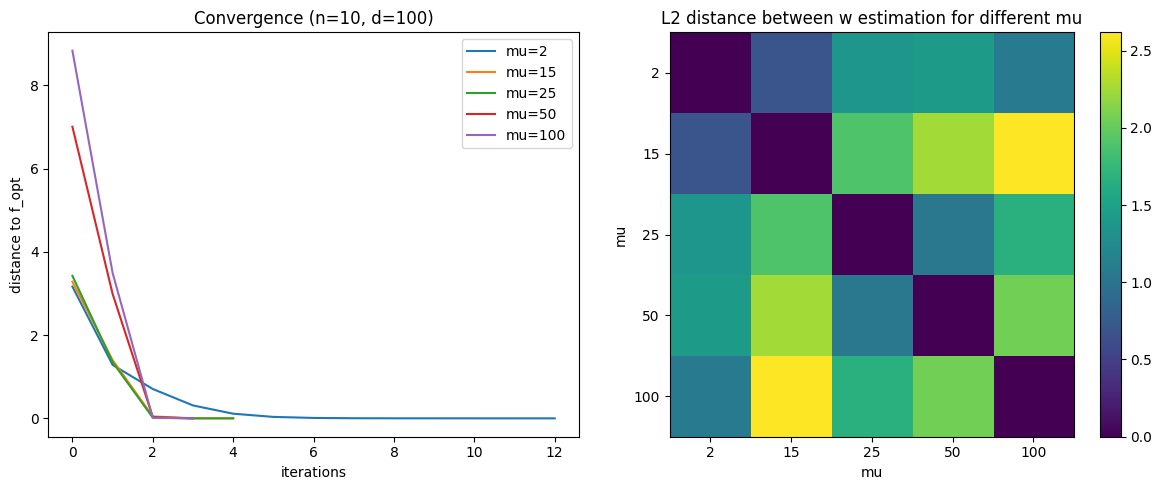

In [13]:
lambda_val = 10
n = 10
d = int(1e2)
mu_list = [2, 15, 25, 50, 100]
plot_all_in_one(n, d, mu_list, lambda_val)

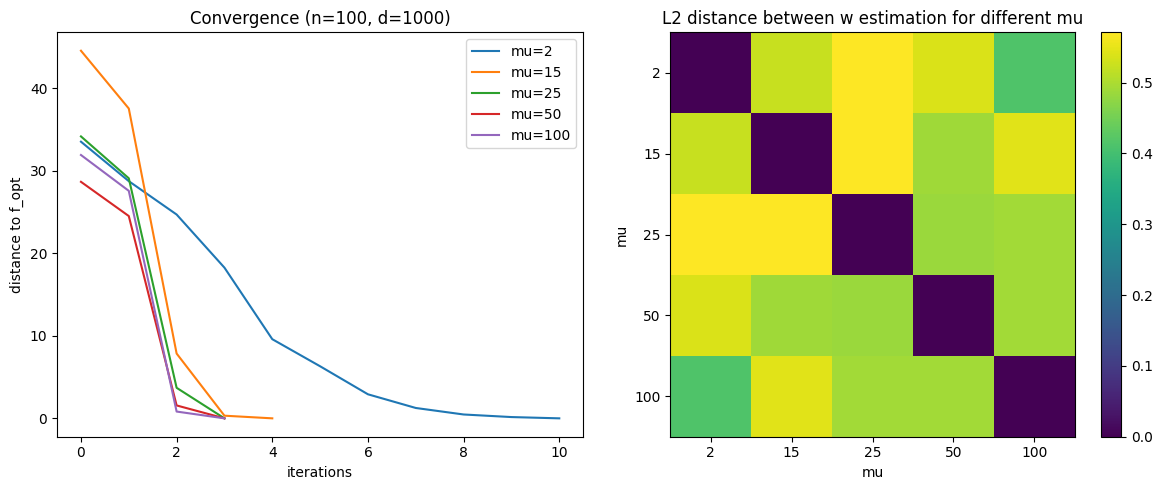

In [9]:
n = 100
d = int(1e3)
mu_list = [2, 15, 25, 50, 100]
plot_all_in_one(n, d, mu_list)

**observation**: increasing $\mu$ reduces the number of iterations and, considering the high-dimension $w$ is in, the mse between ($w_{\mu}$) is small. So a high value of $\mu$ like 50 or 100 should be selected so as to have fewer steps and faster computation.